# Working with INCEpTION slot features in DKPro Cassis

Let's first create a `requirements.txt` file from which we install all necessary Python dependencies.


In [ ]:
%%writefile requirements.txt
# We use a direct commit reference here because we use types instead of type
# names as arguments in the select calls.
# See: https://github.com/dkpro/dkpro-cassis/issues/217
# If you want to try this code with cassis 0.7.x, you would need to use e.g.
# `cas.select(SemPred.name)` instead of `cas.select(SemPred)`
dkpro-cassis @ git+https://github.com/dkpro/dkpro-cassis@95a9d4ce99e1d932e1a587586152a8d1ffc23875

Now let's install the dependencies.

In [ ]:
!pip install -r requirements.txt

Next, we provide ourselves with an UIMA type system description. This is an XML file which we can get for example by going to the **Project settings** in INCEpTION, navigating to the **Layers** tab there, selecting any layer, and then using the **Export** button from the **Layer** pane to export **UIMA (all layers)**.

The particular example below was exported from a project created using the **Empty project** template and then adding the built-in **Predicate argument structure** layers from the **Create** dropdown in the **Layers** tab of the **Project settings**.

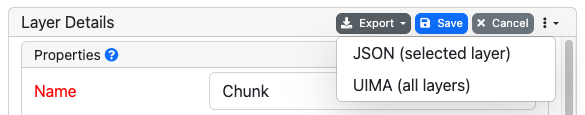

In [ ]:
%%writefile typesystem.xml
<?xml version="1.0" encoding="UTF-8"?>
<typeSystemDescription xmlns="http://uima.apache.org/resourceSpecifier">
    <types>
        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArg</name>
            <supertypeName>uima.tcas.Annotation</supertypeName>
        </typeDescription>

        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArgLink</name>
            <supertypeName>uima.cas.TOP</supertypeName>
            <features>
                <featureDescription>
                    <name>role</name>
                    <rangeTypeName>uima.cas.String</rangeTypeName>
                </featureDescription>
                <featureDescription>
                    <name>target</name>
                    <rangeTypeName>de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArg</rangeTypeName>
                </featureDescription>
            </features>
        </typeDescription>
                
        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemPred</name>
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features>
                <featureDescription>
                    <name>arguments</name>
                    <rangeTypeName>uima.cas.FSArray</rangeTypeName>
                    <elementType>de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArgLink</elementType>
                </featureDescription>
                <featureDescription>
                    <name>category</name>
                    <rangeTypeName>uima.cas.String</rangeTypeName>
                </featureDescription>
            </features>
        </typeDescription>
    </types>
</typeSystemDescription>

Now, we can load the type system definition and fetch a few annotation types from it to work with.

In [ ]:
from cassis import *
from pathlib import Path
from cassis.typesystem import TYPE_NAME_FS_ARRAY

typesystem = load_typesystem(Path('typesystem.xml'))
FSArray = typesystem.get_type(TYPE_NAME_FS_ARRAY)
SemPred = typesystem.get_type('de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemPred')
SemArg = typesystem.get_type('de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArg')
SemArgLink = typesystem.get_type('de.tudarmstadt.ukp.dkpro.core.api.semantics.type.SemArgLink')

Now, we create ourselves CAS object which will hold the document text as well as the annotations. 

Then we add a basic predicate argument structure consisting of three annotations:

* `arg_0` (type: `SemArg`) - we use it to annotate the "buyer" actor (i.e. the subject).
* `arg_1` (type: `SemArg`) - we use it to annotate the "bought" item (i.e. the object).
* `frame` (type: `SemPred`) - we use it to annotate the action (i.e. predicate). This annotation also contain a **slot feature** `arguments` that is used to link to the arguments (`arg_0`, `arg_1`; type `SemArgLink`)

Once everything has been added to the CAS, we dump it as XMI to have a brief look.

In [ ]:
cas = Cas(typesystem=typesystem)
#                            1         2
#                  0123456789012345678901234
cas.sofa_string = "Andrea bought a new car."

arg_0 = SemArg(begin=0, end=6)
arg_1 = SemArg(begin=14, end=23)
frame = SemPred(begin=7, end=13)
frame.arguments=FSArray(elements=[SemArgLink(role="buyer", target=arg_0), SemArgLink(role="bought", target=arg_1)])
cas.add_all([arg_0, arg_1, frame])

print(cas.to_xmi(pretty_print=True))

Now, let's see how we can again retrieve the predicate argument structure from the CAS.

In [ ]:
for frame in cas.select(SemPred):
  print(f"Predicate: {frame.get_covered_text()}")
  for arg in frame.arguments.elements:
    print(f"  {arg.role}: {arg.target.get_covered_text()}")
